# FlowPic replication

For the course of this exploration I'll be attempting to replicate salient aspects of [FlowPic: Encrypted Internet Traffic Classification is as Easy as Image Recognition](https://ieeexplore.ieee.org/document/8845315) by Tal Shapira and Yuval Shavitt.

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import ipaddress
from ipaddress import ip_address as IP

import tensorflow as tf
from tensorflow import keras

## Dataset preparations

> We split each pcap file to unidirectional flows,  where  each  flow  is  defined  by  a  5-tuple  {source  IP,source port, destination IP, destination port, protocol}

This suggests the following process/changes to our preprocessing:
- Packet level unbinning should produce multiple dataframes
- Each dataframe needs to have a unique pair of IPs, *direction*, etc.
    - Since we're assuming a VPN is in use, we should be able to clean the data so that only the VPN traffic remains, then we can just split it on direction

In [172]:
raw_files = glob.glob('../data/raw/*-vpn*')
f = np.random.choice(raw_files)
# f = '../data/raw/stdoan-youtube[720p60]-1x-vpn-windows-clean-20201102.csv'
print(f)
df_raw = pd.read_csv(f)
df = src.data.clean(df_raw)
print(df.IP1.unique(), df.IP2.unique())
df

../data/raw/imnemato-youtube[1080p]-1x-vpn-mac-clean-20201031e.csv
['192.168.1.204'] ['137.110.0.70']


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604178943,192.168.1.204,54800,137.110.0.70,443,17,268,0,1,0,1604178943115;,268;,1;
1,1604178944,192.168.1.204,54800,137.110.0.70,443,17,460,586,3,3,1604178944471;1604178944471;1604178944472;1604...,224;224;138;150;172;138;,2;2;1;1;1;2;
4,1604178945,192.168.1.204,54800,137.110.0.70,443,17,308,304,2,2,1604178945640;1604178945676;1604178945708;1604...,170;138;166;138;,1;2;2;1;
5,1604178948,192.168.1.204,54800,137.110.0.70,443,17,11404,1010984,71,752,1604178948394;1604178948394;1604178948430;1604...,1366;516;138;1346;1346;1346;1346;1346;1346;134...,1;1;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;...
6,1604178949,192.168.1.204,54800,137.110.0.70,443,17,309,320,2,2,1604178949490;1604178949490;1604178949495;1604...,182;138;171;138;,2;1;1;2;
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1604179234,192.168.1.204,54800,137.110.0.70,443,17,19960,1461591,133,1087,1604179234893;1604179234893;1604179234928;1604...,1366;516;138;1346;1346;1346;1346;1346;1346;134...,1;1;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;...
249,1604179235,192.168.1.204,54800,137.110.0.70,443,17,1380,0,10,0,1604179235000;1604179235000;1604179235000;1604...,138;138;138;138;138;138;138;138;138;138;,1;1;1;1;1;1;1;1;1;1;
258,1604179238,192.168.1.204,54800,137.110.0.70,443,17,308,166,2,1,1604179238561;1604179238620;1604179238620;,170;166;138;,1;2;1;
259,1604179239,192.168.1.204,54800,137.110.0.70,443,17,18442,1511696,122,1124,1604179239901;1604179239901;1604179239934;1604...,1366;516;138;1346;1346;1346;1346;1346;1346;134...,1;1;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;...


The cleaning isn't perfect. May need to revisit.

- Sometimes there are lots of 260x:x IPv6 communications, with many different addresses -- but they seem to be very important and contain the bulk of the packets. (See stdoan files)
- Sometimes there are communications where the VPN IP is in column 1 -- this should be addressed by splitting by direction... but also needs splitting by IP if we're going to split by direction...
- Sometimes there are *tons* of communications with "Shared Address Space" IPs -- again making there be *tons* of IPs that (I think) are truly contibuting to the same flow. (See arv020 files)
- Often there are non-vpn IPs that are still included

In [173]:
def unbin_packets(df):
    """
    """
    
    df = df.drop(columns=[
        'Time', '1->2Bytes', '2->1Bytes', '1->2Pkts', '2->1Pkts'
    ])
    
    packet_cols = ['packet_times', 'packet_sizes', 'packet_dirs']
#     packetlist_cols = [s.rstrip('s') for s in packet_cols]
    
    # Convert the strings `val1;val2;` into lists `[val1, val2]`
    df[packet_cols] = (
        df.loc[:,packet_cols]
        .apply(lambda ser: ser.str.split(';').str[:-1])
    )
    
    # 'Explode' the lists so each element gets its own row.
    exploded = (
        df
        .apply(
            lambda ser: ser.explode().astype(int) if ser.name in packet_cols else ser
        )
    )
    
    return exploded

In [174]:
unbinned = unbin_packets(df)

Perhaps if a particular flow constitutes more than x% of the unbinned data then we should single it out?

In [175]:
from functools import reduce

def dominating_flow(df, threshold=0.9):
    
    ip1_props = df.IP1.value_counts(normalize=True)
    ip2_props = df.IP2.value_counts(normalize=True)
    
    masks = []
    
    if ip1_props[0] > threshold:
        masks.append(
            df.IP1 == ip1_props.index[0]
        )
        
    if ip2_props[0] > threshold:
        masks.append(
            df.IP2 == ip2_props.index[0]
        )
        
    if masks:
        return df[reduce(lambda x, y: y & x, masks, True)]
    else:
        return df

In [176]:
dom = dominating_flow(unbinned)
dom

,IP1,Port1,IP2,Port2,Proto,packet_times,packet_sizes,packet_dirs
0,192.168.1.204,54800,137.110.0.70,443,17,1604178943115,268,1
1,192.168.1.204,54800,137.110.0.70,443,17,1604178944471,224,2
1,192.168.1.204,54800,137.110.0.70,443,17,1604178944471,224,2
1,192.168.1.204,54800,137.110.0.70,443,17,1604178944472,138,1
1,192.168.1.204,54800,137.110.0.70,443,17,1604178944472,150,1
...,...,...,...,...,...,...,...,...
259,192.168.1.204,54800,137.110.0.70,443,17,1604179239986,138,1
260,192.168.1.204,59664,137.110.0.70,443,6,1604179243486,89,1
260,192.168.1.204,59664,137.110.0.70,443,6,1604179243526,52,2
260,192.168.1.204,59664,137.110.0.70,443,6,1604179243528,89,2


Let's split up by ip pairs and direction.

Afterwards, if our data had a bunch of IPs, we can chuck out dataframes that are too small or something like that.

In [177]:
keys = ['IP1', 'IP2', 'packet_dirs']

indexed = (
    dom
    .sort_values(keys)
    .set_index(keys)
)
indexed

Port1  Port2  Proto   packet_times  \
IP1           IP2          packet_dirs                                       
192.168.1.204 137.110.0.70 1            54800    443     17  1604178943115   
                           1            54800    443     17  1604178944472   
                           1            54800    443     17  1604178944472   
                           1            54800    443     17  1604178944475   
                           1            54800    443     17  1604178945640   
...                                       ...    ...    ...            ...   
                           2            54800    443     17  1604179239985   
                           2            54800    443     17  1604179239985   
                           2            54800    443     17  1604179239985   
                           2            59664    443      6  1604179243526   
                           2            59664    443      6  1604179243528   

                                        packet_sizes  
IP1           IP2          packet_dirs                
192.168.1.204 137.110.0.70 1                     268  
                           1                     138  
                           1                     150  
                           1                     172  
                           1                     170  
...                                              ...  
                           2                    1346  
                           2                    1346  
                           2                    1346  
                           2                      52  
                           2                      89  

[80523 rows x 5 columns]

In [178]:
indexed.index.value_counts(normalize=True)

(192.168.1.204, 137.110.0.70, 2)    0.817021
(192.168.1.204, 137.110.0.70, 1)    0.182979
dtype: float64

Just looked at a file with tons of the 260x IPs... I don't know how to deal with those.

For the moment might just chuck out dataframes that don't boil down to two index levels.

In [179]:
assert max(indexed.index.levshape) == 2, f'Too many IPs in the data! {indexed.index.levshape}'

## Data Augmentation

> we  divide  each  unidirectional  flow  to  60  seconds  blocks

In [194]:
fidx = indexed.index.unique()

download_idx = np.argwhere(fidx.levels[2] == 2)[0][0]

down = indexed.loc[fidx[download_idx]]
up = indexed.loc[fidx[1-download_idx]]

In [232]:
def chunk(df, chunk_length='60s'):
    """
    Returns a list of DataFrames, each `chunk_length` long in duration.
    """
    
    df['timestamp'] = pd.to_datetime(df.packet_times, unit='ms')
    resampled = df.resample(chunk_length, on='timestamp')

    chunks = []
    for (timestamp, frame) in resampled:
        chunks.append(frame)

    # Get rid of last chunk if it's incomplete
    last = chunks[-1]
    if last.timestamp.max() - last.timestamp.min() < pd.Timedelta(chunk_length):
        chunks.pop()

    return chunks

In [233]:
chunks = chunk(down)

In [234]:
chunks[0]

Port1  Port2  Proto   packet_times  \
IP1           IP2          packet_dirs                                       
192.168.1.204 137.110.0.70 2            54800    443     17  1604178944471   
                           2            54800    443     17  1604178944471   
                           2            54800    443     17  1604178944544   
                           2            54800    443     17  1604178945676   
                           2            54800    443     17  1604178945708   
...                                       ...    ...    ...            ...   
                           2            54800    443     17  1604178958009   
                           2            54800    443     17  1604178958009   
                           2            54800    443     17  1604178958009   
                           2            54800    443     17  1604178958009   
                           2            54800    443     17  1604178958009   

                                        packet_sizes               timestamp  
IP1           IP2          packet_dirs                                        
192.168.1.204 137.110.0.70 2                     224 2020-10-31 21:15:44.471  
                           2                     224 2020-10-31 21:15:44.471  
                           2                     138 2020-10-31 21:15:44.544  
                           2                     138 2020-10-31 21:15:45.676  
                           2                     166 2020-10-31 21:15:45.708  
...                                              ...                     ...  
                           2                    1346 2020-10-31 21:15:58.009  
                           2                    1346 2020-10-31 21:15:58.009  
                           2                    1346 2020-10-31 21:15:58.009  
                           2                    1346 2020-10-31 21:15:58.009  
                           2                    1346 2020-10-31 21:15:58.009  

[3453 rows x 6 columns]

## FlowPic Construction

> {IP packet size, time of arrival}

> At the first stage, we plot all record  pairs by  defining  our  X-axis  as  the  packet  arrival time, and  Y-axis  as  the  packet  size.

> An  absolute  majority  of the  packet  sizes  do  not  cross  the  1500  bytes  (which  is  the Ethernet MTU value), thus we disregard all packets with size greater  than  1500  (less  than  5%  of  all  packets),  and  limit our  Y-axis to  be  between 1  to  1500.

> For  the  X-axis, first  we normalize  all  time  of  arrival  values  by  subtracting  the  time of  arrival  of  the  first  packet  in  the  flow.  For  simplicity,  we set the 2D-histogram to be a square image. For this purpose, we  normalized  all  time  of  arrival  values  to  be  between  0 to  1500  (namely,  60  seconds  is  mapped  to  1500).

In [270]:
def flowpic(chunk, bins=1500, draw=False, draw_binary=False):
    
    c = chunk[['packet_times', 'packet_sizes']]

    c = c[c.packet_sizes <= 1500]
    c.packet_times = c.packet_times - c.packet_times.min()
    c.packet_times = c.packet_times / c.packet_times.max() * 1500
    
    h = np.histogram2d(c.packet_times, c.packet_sizes, bins=bins)[0]
    h = h / h.max()
    
    if draw:
        options = {'cmap': 'Greys', 'origin': 'lower', 'vmin': 0, 'vmax': 1}
        if draw_binary:
            plt.imshow(h.T > 0, **options)
        else:
            plt.imshow(h.T, **options)
        plt.xlabel('Normalized arrival time')
        plt.ylabel('Packet size (bytes)')

    return h

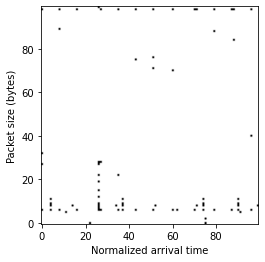

In [276]:
h = flowpic(chunks[4], bins=100, draw=True, draw_binary=True)

**Note**: Our data doesn't look nearly as dense as in the paper -- maybe our cleaning was a bit extreme?